In [1]:
# Work 13
# Data Visualization in paper
# Plotting map - distribution of e-scooter accidents and pseudo-absence points
# Preparing illustration figures: SAM examples, curb extraction examples

In [2]:
# loading libraries
import torch
torch.cuda.empty_cache()  
# pip install geoplot
import geoplot
import sys
print(sys.version)
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:100000"
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import cv2
os.getcwd()

3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:34:09) [GCC 12.3.0]


'/home/yelhe/mtp_agile'

In [3]:
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117
CUDA is available: True


In [9]:
import glob
import shapely
from shapely.geometry import Point, Polygon
import shapely.plotting
import pandas as pd
from PIL import Image as ima
import warnings
from pathlib import Path
import pandas as pd
import pyproj
import shapefile as shp
import seaborn as sns
import geopandas as gpd
import folium
import scipy

from shapely.geometry import box
import geopandas as gpd
import earthpy as et
import cartopy
from cartopy.io.img_tiles import OSM
import cartopy.crs as ccrs
from math import floor
from matplotlib import patheffects

In [ ]:
if os.name == 'nt':
    matplotlib.rc('font', family='Arial')
else:  # might need tweaking, must support black triangle for N arrow
    matplotlib.rc('font', family='DejaVu Sans')

def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.5, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2 + 0.3*(x1-x0), 
              sbcx + length * m_per_unit/2 + 0.3*(x1-x0)]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx + 0.3*(x1-x0), sbcy + 0.01*(y1-y0), str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.1
    # Plot the N arrow
    t1 = ax.text(left, sbcy + 0.8*(y1-y0), u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=3)

if __name__ == '__main__':

    ax = plt.axes(projection=ccrs.Mercator())
    plt.title('Cyprus')
    ax.set_extent([31, 35.5, 34, 36], ccrs.Geodetic())
    ax.stock_img()
    ax.coastlines(resolution='10m')

    scale_bar(ax, ccrs.Mercator(), 100)  # 100 km scale bar
    # or to use m instead of km
    # scale_bar(ax, ccrs.Mercator(), 100000, m_per_unit=1, units='m')
    # or to use miles instead of km
    # scale_bar(ax, ccrs.Mercator(), 60, m_per_unit=1609.34, units='miles')

    # plt.show()

### Data Visualization

In [16]:
# loading shapefiles of city of zurich and background map (difference between citu of zurich and kanton zurich)
zur = gpd.read_file('/home/yelhe/data/geodata/cityzurich.shp')
dz = gpd.read_file('/home/yelhe/data/geodata/differ_zur.shp')
zur = zur.to_crs(img.crs)
dz = dz.to_crs(img.crs)

In [10]:
# loading coordinate data of e-scooter accidents
koord = pd.read_csv('/home/yelhe/script/mt/output/koord.csv')
# loading cooordinate data of random pseudo-absence points
koord_rp = pd.read_csv('/home/yelhe/script/mt/output/rp_koord_new.csv')

In [94]:
img = OSM()
img.crs

/home/yelhe/.local/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


<Bound CRS: +proj=merc +a=6378137.0 +b=6378137.0 +nadgrids=@nu ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown to WGS84
- method: NTv2
Datum: unknown using nadgrids=@null
- Ellipsoid: unknown
- Prime Meridian: Greenwich
Source CRS: unknown

In [13]:
# setting coordinate reference system and creating GeoDataFrame
crs={'init':'epsg:4326'}
geometry=[Point(xy) for xy in zip(koord['lon'], koord['lat'])]
geodata=gpd.GeoDataFrame(koord, crs=crs, geometry=geometry)
geodata = geodata.to_crs(img.crs)
geometry_rp=[Point(xy) for xy in zip(koord_rp['lon'], koord_rp['lat'])]
geodata_rp = gpd.GeoDataFrame(koord_rp, crs=crs, geometry=geometry_rp)
geodata_rp = geodata_rp.to_crs(img.crs)

/home/yelhe/.local/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


/home/yelhe/.local/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS 84 e ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


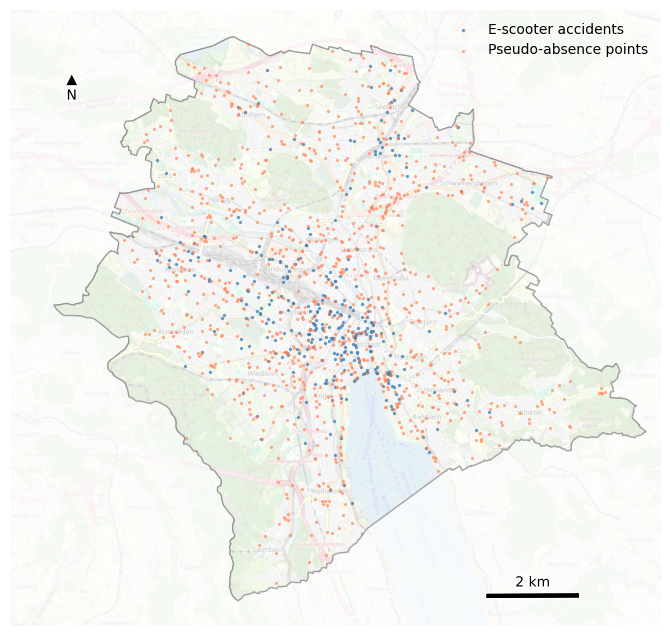

In [461]:
plt.figure(figsize = (12,8))
img = OSM()
ax = plt.axes(projection = img.crs)
# print(img.crs)
ax.add_image(img, 13)
ax.set_extent([8.435, 8.630, 47.315, 47.44])
dz.plot(ax = ax, facecolor = 'white', alpha = 0.9, linewidth = 0.5)
zur.plot(ax = ax, facecolor = 'white', alpha = 0.7, linewidth = 1, edgecolor = 'grey')
geodata.plot(ax=ax, color = 'steelblue', markersize = 2, legend = True,alpha = 0.7,
             label = 'E-scooter accidents')
geodata_rp.plot(ax=ax, color = 'coral', markersize = 2, legend = True, alpha = 0.5,
             label = 'Pseudo-absence points')
ax.legend(frameon = False)
scale_bar(ax, ccrs.PlateCarree(), 2)
plt.box(False)
# plt.savefig('ac_and_rp_point1_correct.png', dpi = 300, edgecolor = None, 
#              transparent = True, bbox_inches = 'tight')

### Illustration figures

In [4]:
# example figures for Segment Anything model
# loading libraries for Segment Anything Model
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="/home/yelhe/data/sam/sam_vit_h_4b8939.pth")

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
mask_generator = SamAutomaticMaskGenerator(sam)


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    # polygons = []
    # color = []
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    # for ann in sorted_anns:
    #     m = ann['segmentation']
    #     img = np.ones((m.shape[0], m.shape[1], 3))
    #     color_mask = np.random.random((1, 3)).tolist()[0]
    #     for i in range(3):
    #         img[:,:,i] = color_mask[i]
    #     ax.imshow(np.dstack((img, m*0.35)))

# # Add new function def write_masks_to_png (codes from the readme of sam github repository).
# def write_masks_to_png(masks: List[Dict[str, Any]], image, path: str) -> None:
#     plt.figure(figsize=(20,20))
#     plt.imshow(image)
#     show_anns(masks)
#     plt.axis('off')
#     #plt.show()
#     filename = f"masks.png"
#     plt.savefig(os.path.join(path, filename))
#     return

In [6]:
# loading raw images for example of applying SAM
# imageo = cv2.imread("/home/yelhe/data/illustration_images/rawimage_samexample.jpg")
imageo = cv2.imread("/home/yelhe/mtp_agile/06.jpg")
imageo = cv2.cvtColor(imageo, cv2.COLOR_BGR2RGB)
maskso = mask_generator.generate(imageo)

<function matplotlib.pyplot.show(close=None, block=None)>

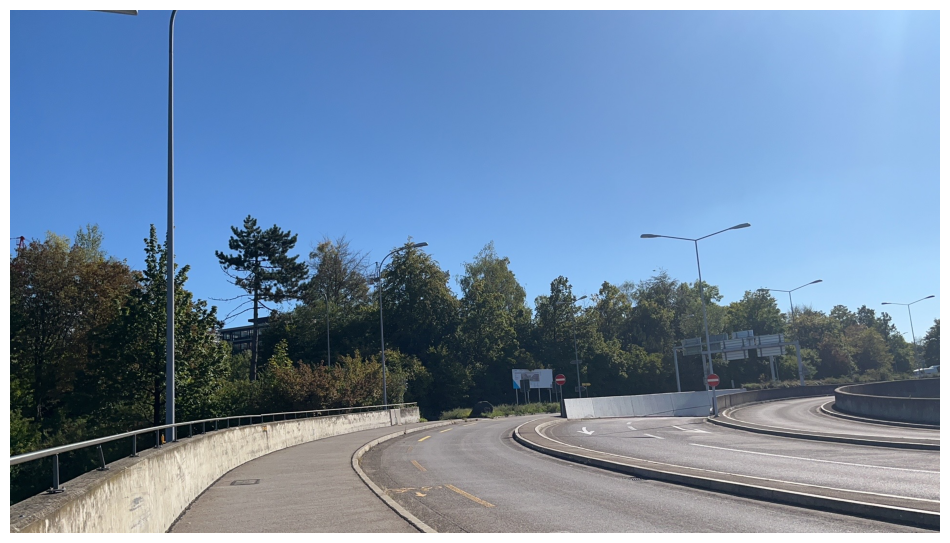

In [8]:
# plotting raw images
plt.figure(figsize = (12,8))
plt.imshow(imageo)
plt.axis('off')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

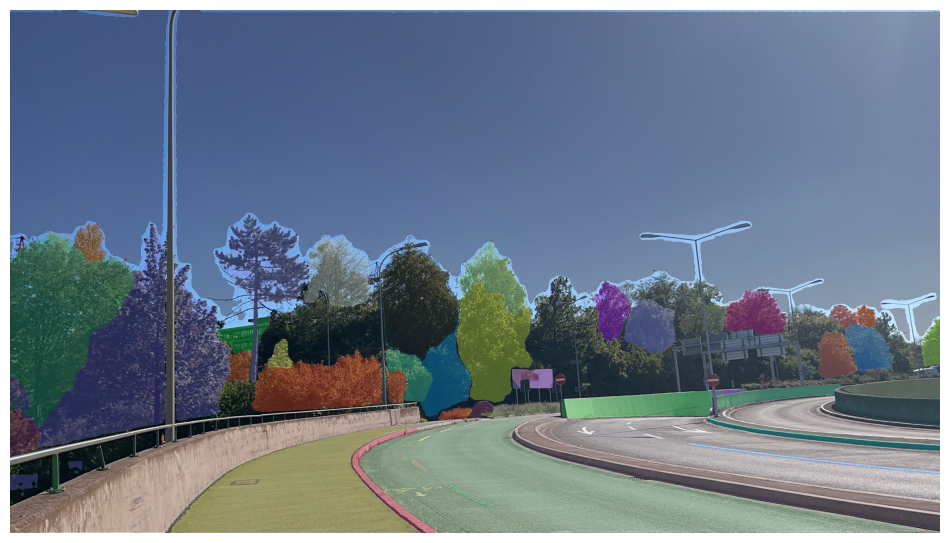

In [9]:
# plotting masks of segment anything model output
plt.figure(figsize = (12,8))
plt.imshow(imageo)
show_anns(maskso)
plt.axis('off')
plt.show

In [ ]:
# example figures for curb extraction

In [16]:
# loading images
n = '99900051076121'
n1 = n + '1'
n2 = n + '2'
n3 = n + '3'
n4 = n + '4'
im1 = cv2.imread("/home/yelhe/data/gsv/GSV_filtered/" + n1)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.imread("/home/yelhe/data/gsv/GSV_filtered/" + n2)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
im3 = cv2.imread("/home/yelhe/data/gsv/GSV_filtered/" + n3)
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
im4 = cv2.imread("/home/yelhe/data/gsv/GSV_filtered/" + n4)
im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2RGB)
# loading filtered mask files
m1 = np.load('/home/yelhe/data/gsv_output_filtered/' + n1 + 'f.npy', allow_pickle=True)
m2 = np.load('/home/yelhe/data/gsv_output_filtered/' + n2 + 'f.npy', allow_pickle=True)
m3 = np.load('/home/yelhe/data/gsv_output_filtered/' + n3 + 'f.npy', allow_pickle=True)
m4 = np.load('/home/yelhe/data/gsv_output_filtered/' + n4 + 'f.npy', allow_pickle=True)
# loading file of predicted labels of masks after applying classification model for curb extraction
dfce_pl = pd.read_csv('/home/yelhe/script/mt/output/pred_accident_label.csv')


# local environment - loading for checking
# im1 = cv2.imread('../mtfi_shortpaper/output/' + n1 + '.jpg')
# im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
# im2 = cv2.imread('../mtfi_shortpaper/output/' + n2 + '.jpg')
# im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
# im3 = cv2.imread('../mtfi_shortpaper/output/' + n3 + '.jpg')
# im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
# im4 = cv2.imread('../mtfi_shortpaper/output/' + n4 + '.jpg')
# im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2RGB)
# m1 = np.load('../mtfi_shortpaper/output/' + n1 + 'f.npy', allow_pickle=True)
# m2 = np.load('../mtfi_shortpaper/output/' + n2 + 'f.npy', allow_pickle=True)
# m3 = np.load('../mtfi_shortpaper/output/' + n3 + 'f.npy', allow_pickle=True)
# m4 = np.load('../mtfi_shortpaper/output/' + n4 + 'f.npy', allow_pickle=True)
# dfce_pl = pd.read_csv('../mtfi_shortpaper/output/pred_accident_label.csv')

In [47]:
# converting data type
dfce_pls = dfce_pl[['mask', 'Nr', 'p']]
dfce_pls['Nr'] = dfce_pls['Nr'].apply(str)
dfce_pls['p'] = dfce_pls['p'].apply(str)
# selecting masks labelled as 'curb' from the predicted result in these four images
df_pred_img1 = dfce_pl.loc[(dfce_pls['Nr'] == n1) & (dfce_pls['p'] == '0')]
df_pred_img2 = dfce_pl.loc[(dfce_pls['Nr'] == n2) & (dfce_pls['p'] == '0')]
df_pred_img3 = dfce_pl.loc[(dfce_pls['Nr'] == n3) & (dfce_pls['p'] == '0')]
df_pred_img4 = dfce_pl.loc[(dfce_pls['Nr'] == n4) & (dfce_pls['p'] == '0')]

5


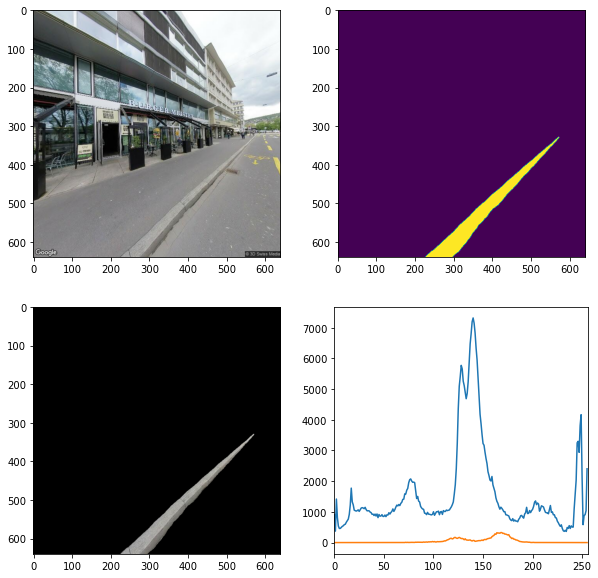

In [131]:
# plotting the image and the mask predicted with a label of 'curb'
j = (df_pred_img1['mask'].tolist())[0]-1
print(j)
mb = m1[j]
img = im1
maskedimg = cv2.bitwise_and(img,img,mask = mb)
# # create a mask
hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([img],[0],mb,[256],[0,256])
plt.figure(figsize = (10,10))
plt.subplot(221), plt.imshow(img)
plt.subplot(222), plt.imshow(mb)
plt.subplot(223), plt.imshow(maskedimg)
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0,256])
plt.show()

13


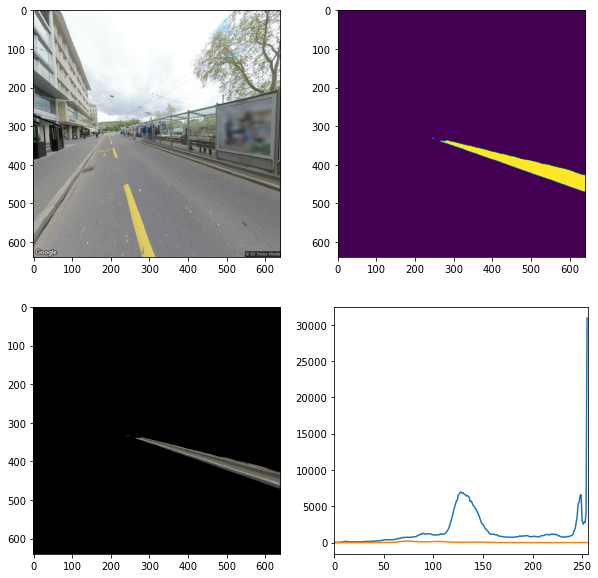

In [132]:
# plotting the image and the mask predicted with a label of 'curb'
j = (df_pred_img2['mask'].tolist())[0]-1
print(j)
mb = m2[j]
img = im2
maskedimg = cv2.bitwise_and(img,img,mask = mb)
# # create a mask
hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([img],[0],mb,[256],[0,256])
plt.figure(figsize = (10,10))
plt.subplot(221), plt.imshow(img)
plt.subplot(222), plt.imshow(mb)
plt.subplot(223), plt.imshow(maskedimg)
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0,256])
plt.show()

19


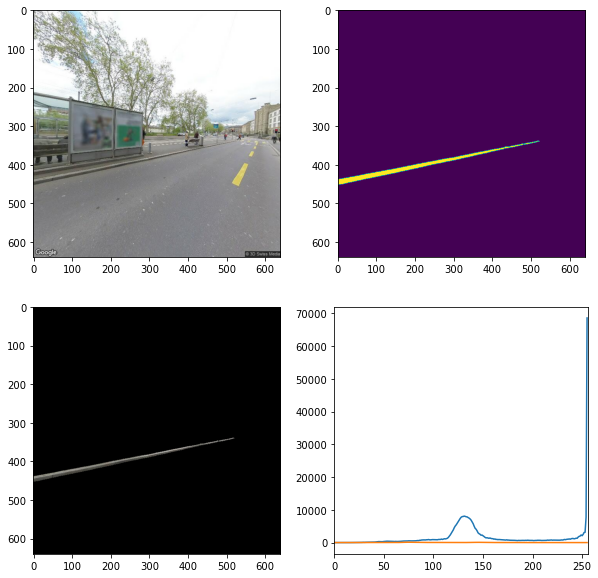

In [133]:
# plotting the image and the mask predicted with a label of 'curb'
j = (df_pred_img3['mask'].tolist())[0]-1
print(j)
mb = m3[j]
img = im3
maskedimg = cv2.bitwise_and(img,img,mask = mb)
# # create a mask
hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([img],[0],mb,[256],[0,256])
plt.figure(figsize = (10,10))
plt.subplot(221), plt.imshow(img)
plt.subplot(222), plt.imshow(mb)
plt.subplot(223), plt.imshow(maskedimg)
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0,256])
plt.show()

5


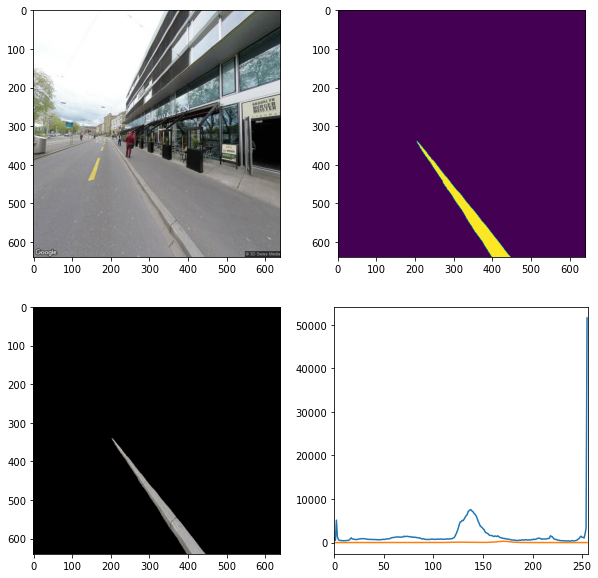

In [134]:
# plotting the image and the mask predicted with a label of 'curb'
j = (df_pred_img4['mask'].tolist())[0]-1
print(j)
mb = m4[j]
img = im4
maskedimg = cv2.bitwise_and(img,img,mask = mb)
# # create a mask
hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([img],[0],mb,[256],[0,256])
plt.figure(figsize = (10,10))
plt.subplot(221), plt.imshow(img)
plt.subplot(222), plt.imshow(mb)
plt.subplot(223), plt.imshow(maskedimg)
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0,256])
plt.show()